# Test the resolution of one-body hamiltonian based on one ACDM D0 = (A0,C0)

In [1]:
import numpy as np
import scipy.optimize

#Size of X (to use scipy.optimize.root, we need a vector)
def Size_X():
    n0 = pA0+pC0+n2+1  #A0[n,n] C0[n,n] Lambda0[n,n] mu0
    return n0

#Return label and postion for testing the gradient
def label():
    text = [ 'A0','C0','Lambda0','mu0' ]
    pos = [ 0, pA0, pA0+pC0, pA0+pC0+n2 ]
    return text,pos

#Pack A0, C0, Lambda0, mu0 into X
def Pack_X(A0,C0,Lambda0,mu0):
    X = np.zeros(Size_X())
    X[0:pA0] = np.reshape(A0,n*n)
    n0 = pA0+pC0
    X[pA0:n0] = np.reshape(C0,n*n)
    X[n0:n0+n2] = np.reshape(Lambda0,[n*n])
    X[n0+n2] = mu0
    return X

#Depack X into A0, C0, Lambda0, mu0
def Depack_X(X):
    A0 = np.reshape(X[0:pA0],[n,n])
    n0 = pA0+pC0
    C0 = np.reshape(X[pA0:n0],[n,n])
    Lambda0 = np.reshape(X[n0:n0+n2],[n,n])
    mu0 = X[n0+n2]
    return A0,C0,Lambda0,mu0

#Initial Guess based on H1
def Initial_X():
    L,U = np.linalg.eigh(h1)
    #First A0, C0, Lambda and mu
    print('Initial',L[:N],np.sum(L[:N]))
    mu0 = L[N]
    L_A0 = np.zeros(n)
    L_C0 = np.zeros(n)
    L_Lambda0 = np.zeros(n)
    for i in range(N):
        L_A0[i] = 1.0 #N occupation number to 1
        L_Lambda0[i] = L[i] - mu0
    for i in range(N,n):
        L_C0[i] = 1.0 #n-N hole to one
    A0 = np.einsum('ij,jm->im',U,np.diag(L_A0))
    C0 = np.einsum('ij,jm->im',U,np.diag(L_C0))
    Lambda0 = U@np.diag(L_Lambda0)@U.T
    return Pack_X(A0,C0,Lambda0,mu0)


def Hamiltonian_Energy(X):
    A0,C0,Lambda0,mu0 = Depack_X(X)
    return np.einsum('ij,im,jm->',h1,A0,A0)

#Constraints for D0
def D0_Constraints(A0,C0):
    return np.einsum('im,jm->ij',A0,A0) + np.einsum('im,jm->ji',C0,C0) - np.eye(n)

#Constraints for A0
def A0_Constraints(A0):
    return (np.einsum('im,im->',A0,A0) - np.float64(N))

#Lagrangian
def Lagrangian(X):
    A0,C0,Lambda0,mu0 = Depack_X(X)
    return np.einsum('ij,im,jm->',h1,A0,A0) \
        - mu0 * A0_Constraints(A0) - np.einsum('ij,ij->',Lambda0,D0_Constraints(A0,C0))

#Gradient of Lagrangian
def Gradient_Lagrangian(X):
    A0,C0,Lambda0,mu0 = Depack_X(X)
    HH = h1 - Lambda0 - mu0*np.eye(n)
    GA0 = np.einsum('ij,jm->im',HH,A0) + np.einsum('ij,im->jm',HH,A0)
    GC0 = - np.einsum('iI,im->Im',Lambda0,C0) - np.einsum('iI,Im->im',Lambda0,C0)
    GLambda0 = - D0_Constraints(A0,C0)
    Gmu0 = - A0_Constraints(A0)
    return Pack_X(GA0,GC0,GLambda0,Gmu0)

#Testing the gradient
def test_Gradient_Lagrangian(X0,d,text,pos):
    L0 = Lagrangian(X0)
    GX0 = Gradient_Lagrangian(X0)
    diff = np.zeros(len(X0))
    #To label the abscissae
    #
    p = 0
    for l in range(len(X0)):
        X1 = X0.copy()
        X1[l] += d
        L1 = Lagrangian(X1)
        diff[l] = (L1-L0)/d
        #print(l,X0[l],X1[l],L0,L1,GX0[l],diff[l])
        dd = abs(GX0[l]-diff[l])
        if p < len(pos)-1 and l>=pos[p+1]:
            p += 1
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import figure
    figure(figsize=(16, 6), dpi=80)
    x = np.array(range(len(X0)))
    y = GX0-diff
    for p,t in zip(pos,text):
        plt.text(p,0,t,rotation=90)
    plt.plot(x, GX0)
    plt.plot(x, diff,'--')
    plt.plot(x,y)
    plt.show() 

In [2]:
np.random.seed(1)
ns = 4
Ns = 1
#For pyscf
nelec = (Ns,0)

#Number of orbitals
norb = ns
print('norb',norb,'nelec',nelec)
#Define Hamiltonian
h1 = np.float64(2.0*np.random.random((norb,norb)))
# Restore permutation symmetry
h1 = np.float64(0.5)*(h1 + h1.T)
print('diff h1', max(abs(np.reshape(h1 - h1.T,norb*norb))))

n = ns
N = Ns
#Parameters used to define objects
n2 = n*n
n3 = n*n2
n4 = n2*n2
pA0 = n2        #Number of components for regular A0
pC0 = n2        #Number of components for regular C0

print('n',n,'N',N)
print('Number of components for A0:',pA0)
print('Number of components for C0:',pC0)
print('Total number of parameters for the Lagrangian (A0,C0,lambda0,mu0):',Size_X())
print('-'*30,'Start of Initialization')

X0 = Initial_X()+0.5*np.random.rand(Size_X())
A0,C0,Lambda0,mu0 = Depack_X(X0)
print('mu0',mu0)
print('Initial Energy target',Hamiltonian_Energy(X0), 'Lagrangian Initial target', Lagrangian(X0))
print('Initial Lagrangian gradient',max(abs(Gradient_Lagrangian(X0))) )
print('Max D0_Constraints',max(abs(np.reshape(D0_Constraints(A0,C0),n*n))) )
print('Max A0_Constraints',A0_Constraints(A0))
print('-'*30,'End of Initialization')

sol = scipy.optimize.root(fun=Gradient_Lagrangian, x0=X0,method='krylov',\
                          options={'disp': True, 'xatol': 1.e-8,'xtol': 1.e-7,'fatol': 1.e-9,'maxiter': 300})

root = sol.x
A0,C0,Lambda,mu0 = Depack_X(root)
ier = sol.status
mesg = sol.message
print('Number of electrons',np.trace(A0.T@A0))
print('Number of holes',np.trace(C0.T@C0))
print('Final energy',Hamiltonian_Energy(sol.x), 'Final Lagrangian', Lagrangian(sol.x))
print('Message of fsolve ier=%d:' % ier,mesg)
print('Number of iterations',sol.nit)
print('Max Gradient values',max(sol.fun))

norb 4 nelec (1, 0)
diff h1 0.0
n 4 N 1
Number of components for A0: 16
Number of components for C0: 16
Total number of parameters for the Lagrangian (A0,C0,lambda0,mu0): 49
------------------------------ Start of Initialization
Initial [-0.78057208] -0.7805720810224672
mu0 0.36740961295144764
Initial Energy target 2.336159271030806 Lagrangian Initial target 1.666270563206623
Initial Lagrangian gradient 2.1592010133791204
Max D0_Constraints 1.3617965223979374
Max A0_Constraints 1.686408587740985
------------------------------ End of Initialization
0:  |F(x)| = 1.82366; step 0.173132
1:  |F(x)| = 1.69193; step 0.203512
2:  |F(x)| = 1.94362; step 0.472474
3:  |F(x)| = 1.90865; step 1
4:  |F(x)| = 1.92257; step 0.500029
5:  |F(x)| = 1.92489; step 1
6:  |F(x)| = 1.92301; step 1
7:  |F(x)| = 1.92454; step 1
8:  |F(x)| = 1.92329; step 1
9:  |F(x)| = 1.9243; step 1
10:  |F(x)| = 1.92348; step 1
11:  |F(x)| = 1.92415; step 1
12:  |F(x)| = 2.18533; step 1
13:  |F(x)| = 1.83355; step 1
14:  |F(x

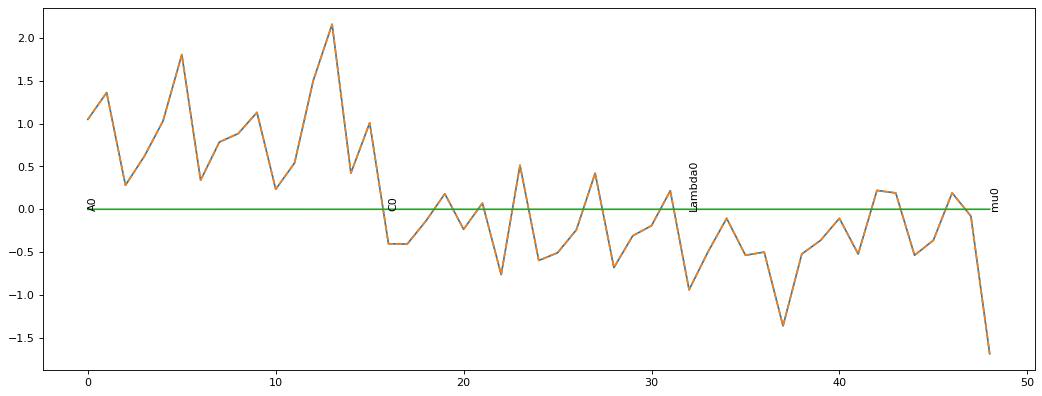

In [3]:
d = 0.0001
text,pos = label()
test_Gradient_Lagrangian(X0,d,text,pos)